# Node Embeddings with Random Weights

> Corresponding to Appendix A.1

## 1. Load dataset
- Using Zachary's karate club network, containing 34 nodes connected by 78 undirected edges (Zachary, 1997)
- Every node is labeled by one of four classes obtained via modularity-based clustering (Brandes et al., 2008)

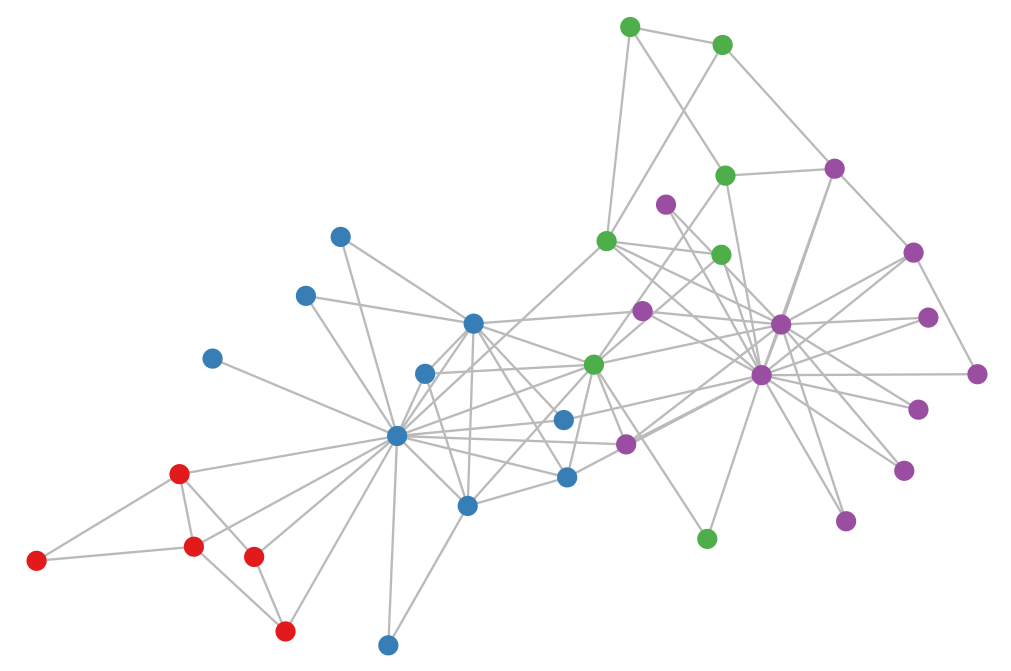

In [12]:
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series

def loadZacharyKarateClubNetwork():
    network = read_edgelist('zachary-karate-club-relation.tsv', nodetype=int)
    communities = read_csv('zachary-karate-club-community.csv', index_col=['id'])
    set_node_attributes(network, 
                        values=Series(communities['community'], index=communities.index).to_dict(),
                        name='community')
    return network

- Take a featureless approach by setting $X=I_N$, where $I_N$ is the $N$ by $N$ identity matrix, $N$ is the number of nodes

In [37]:
from networkx import to_numpy_matrix
import numpy as np

zkc_net = loadZacharyKarateClubNetwork()

A = to_numpy_matrix(zkc_net)
I = np.eye(zkc_net.number_of_nodes())
A_s = A + I

## 2. Build the GCN
- consider the following 3-layer GCN model:
$$Z=\tanh\left(\hat{A}\tanh\left(\hat{A}\tanh\left(\hat{A}XW^{(0)}\right)W^{(1)}\right)W^{(2)}\right)$$
with weight matrices $W^{(i)}$ initialized at random using the initialization described in (Glorot & Bengio, 2010)
- $\hat{A}$ is defined as:
$$\hat{A}=\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$$
- choose a hidden layer dimensionality of 4 and a 2-dimensional output

In [38]:
def gcn_layer(A_s, X, W):
    D_hat = np.diag(np.array(np.power(np.sum(A_s, axis=0), -0.5))[0])
    return np.tanh(D_hat.dot(A_s).dot(D_hat).dot(X).dot(W))

- "normalized initialization”, or “Xavier initialization” now, sets a layer’s weights to values chosen from a random uniform distribution that’s bounded between
$$\pm\frac{\sqrt{6}}{\sqrt{n_i+n_{i+1}}}$$
where $n_i$ is the number of incoming network connections to the layer, and $n_{i+1}$ is the number of outgoing network connections from that layer. Also see [Weight Initialization in Neural Networks: A Journey From the Basics to Kaiming
](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

In [168]:
inputFeature = I

W_0 = np.random.uniform(low=-np.sqrt(6)/np.sqrt(zkc_net.number_of_nodes()+4), 
                        high=np.sqrt(6)/np.sqrt(zkc_net.number_of_nodes()+4), 
                        size=(zkc_net.number_of_nodes(), 4))
W_1 = np.random.uniform(low=-np.sqrt(6)/np.sqrt(W_0.shape[1]+4), 
                        high=np.sqrt(6)/np.sqrt(W_0.shape[1]+4),
                        size=(W_0.shape[1], 4))
W_2 = np.random.uniform(low=-np.sqrt(6)/np.sqrt(W_1.shape[1]+2), 
                        high=np.sqrt(6)/np.sqrt(W_1.shape[1]+2), 
                        size=(W_1.shape[1], 2))

# stack GCN layers
H_1 = gcn_layer(A_s, inputFeature, W_0)
H_2 = gcn_layer(A_s, H_1, W_1)
H_3 = gcn_layer(A_s, H_2, W_2)

output = np.array(H_3)
feature_representations = {
    node: output[node-1] for node in zkc_net.nodes()
}

## 3. Visualization
- visualize the output in a 2-dim plot as node embeddings

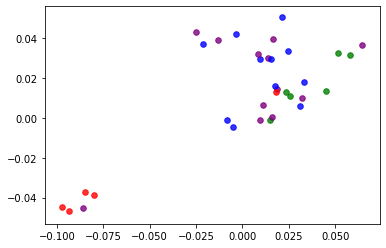

In [169]:
import matplotlib.pyplot as plt 

# c1 - red
# c2 - green
# c3 - blue
# c4 - purple
for i,em in feature_representations.items():
    if zkc_net.nodes[i]['community'] == 'c1':
        plt.scatter(em[0], em[1], color = 'r', alpha=0.8, s = np.pi*10)
    elif zkc_net.nodes[i]['community'] == 'c2':
        plt.scatter(em[0], em[1], color = 'g', alpha=0.8, s = np.pi*10)
    elif zkc_net.nodes[i]['community'] == 'c3':
        plt.scatter(em[0], em[1], color = 'b', alpha=0.8, s = np.pi*10)
    else:
        plt.scatter(em[0], em[1], color = 'purple', alpha=0.8, s = np.pi*10)

In [60]:
np.sqrt(6)

2.449489742783178